# ✨ REST API Usage
---

This notebook explains how Superwise model KPIs can be consumed and analyzed using REST API calls. There are three main parts:

[**1. Connection**](#1.-Connection) - Initiates the mandatory token-based authentication. [More details here](https://docs.superwise.ai/v0.1/docs/authentication). 

[**2. Data consumption**](#2.-Data-consumption) - Explains how to  calculate a specific metric on a data entity [More information about common Superwise concepts.](https://docs.superwise.ai/docs/overview-1).  

[**3. Analyze results**](#3.-Analyze-results) -  Provides examples of trend analysis


## 1. Connection 

To initiate a connection, we first create an API token with permission to send API requests.
To create a token, send a Post request to the route listed below Include your clientId and Secret in the body of the request.
  
[For more about clientID and Secret](https://docs.superwise.ai/v0.1/docs/authentication)     

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
CLIENT_ID = "REPLACE-WITH-YOUR-CLIENTID"
SECRET = "REPLACE-WITH-YOUR-SECRET"
CUSTOMER = "REPLACE-WITH-YOUR-CUSTOMER-NAME"

In [ ]:
url = "https://auth.superwise.ai/identity/resources/auth/v1/api-token"

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json"
}
payload = {
    "clientId": CLIENT_ID,
    "secret": SECRET
}

res = requests.post(url, json=payload, headers=headers)
res.raise_for_status()
token = res.json()['accessToken']

**Set authorization headers**

In [ ]:
HEADERS = {'Authorization': f'Bearer {token}'}
URL_PREFIX = f"https://portal.superwise.ai/{CUSTOMER}"

## 2. Data consumption
Once you create a token, you can start querying data.
Here’s how to get the Data Drift metric for the model's five most important features.
To consume the KPI, provide the following parameters:

- Task and version - Sets the exact model that will compute the KPI.
- Entity ID - The IDs of any of data entities (e.g,. features, labels, predictions, values) on which you want to compute the metric. id=-1 for metrics computed on the entire dataset, regardless of the specific entity (e.g, quantity).
- Metric ID - The ID of the metric for which you want the KPI computed (e.g, data drift, sum_value, entropy etc).   

**For more about the terminology used here, refer to our [glossary](https://docs.superwise.ai/docs/concepts)**

#### 2.1 Consume Task
First, decide which tasks you want to select and make sure you have their IDs and version numbers. 
For more info about tasks, refer to the API [documentation](https://docs.superwise.ai/reference#task).    

In [ ]:
request_url  = f'{URL_PREFIX}/admin/v1/tasks'

res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()
tasks_df = pd.DataFrame(res.json()) 
tasks_df.head()

,active_version_id,active_version_ts,id,monitor_delay,external_id,is_archived,name,description,created_at,time_units
0,NaN,None,19,1,19,True,My new model,desc,2021-12-06T14:03:42.726708,"[D, W]"
1,7.0,2021-08-05T00:00:00,14,1,tmp5,False,Users Segmentation,Cluster users to segments based on their behav...,2021-08-05T00:00:00,[D]
2,7.0,2021-08-05T00:00:00,15,1,tmp6,False,Predictive Maintenance,Estimate when a piece of equipment might fail ...,2021-08-05T00:00:00,[D]
3,7.0,2021-08-05T00:00:00,8,1,fraud8,False,Fraud Detection,Classification model to detect fraudlant onlin...,2021-08-05T00:00:00,"[D, W]"
4,8.0,2021-08-05T00:00:00,10,1,tmp1,False,Churn Prediction,Predict which users are going to churn within ...,2021-08-05T00:00:00,"[D, W]"


**Set the task id and version id of the model**

In [ ]:
task = tasks_df[tasks_df['name'] == 'Fraud Detection']
TASK_ID = int(task['id'])
VERSION_ID = int(task['active_version_id'])

#### 2.2 Consume Entites
**Get all the model’s features and select the five most important ones**    
For more info about data entities, refer to the API [documentation](https://docs.superwise.ai/reference#data-set).    

In [ ]:
request_url  = f'{URL_PREFIX}/model/v1/versions/{VERSION_ID}/data_entities'
res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()

features = pd.DataFrame(res.json())
version_entities = pd.DataFrame(res.json(), columns=["data_entity", "feature_importance"])
flatten_version_entities = pd.json_normalize(version_entities["data_entity"], max_level=0)
flatten_version_entities["feature_importance"] = version_entities["feature_importance"]
empty_flatten_version_entities = pd.DataFrame(
    columns=["id", "name", "role", "type", "secondary_type", "summary", "dimension_start_ts"]
)
features = empty_flatten_version_entities.append(flatten_version_entities)
features = features.sort_values(['feature_importance']).tail(5)[["id","name","type","feature_importance"]]
features.head()

,id,name,type,feature_importance
4,155,customer_id_avg_amount_1day_window,Numeric,0.074043
10,161,terminal_id_risk_1day_window,Numeric,0.082608
14,165,terminal_id_risk_30day_window,Numeric,0.107914
12,163,terminal_id_risk_7day_window,Numeric,0.118199
0,151,tx_amount,Numeric,0.118245


**Set the selected Entites**

In [ ]:
ENTITY_IDS= features.id.to_list()
ENTITY_IDS

[155, 161, 165, 163, 151]

#### 2.3 Get Metrics
To get the data drift metric for the top five most important features, first fetch all the metrics so you can get its ID.

In [ ]:
request_url  = f'{URL_PREFIX}/kpi/v1/metrics-functions'
res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()
metrics = pd.DataFrame(res.json()) 
metrics.head()

,id,name,description,is_overall,type,is_percent,cap,floor,tooltip_text,tooltip_url
0,1,distribution_shift,Distribution Shift,False,distribution,False,100.0,0.0,Measure the statistical distance between the d...,None
1,2,min_value,Min Value,False,distribution,False,NaN,NaN,"For each time frame, the minimal value that wa...",None
2,3,max_value,Max Value,False,distribution,False,NaN,NaN,"For each time frame, the maximal value that wa...",None
3,4,sum_value,Sum Value,False,distribution,False,NaN,NaN,"For each time frame, the sum value that was de...",None
4,5,mean_value,Mean Value,False,distribution,False,NaN,NaN,"For each time frame, the mean value that was d...",None


In [ ]:
metrics.set_index('name').loc['data_drift']

id                                                             11
description                                            Data Drift
is_overall                                                   True
type                                                 distribution
is_percent                                                  False
cap                                                         100.0
floor                                                         0.0
tooltip_text    The overall drift across all model features fo...
tooltip_url                                                  None
Name: data_drift, dtype: object

In [ ]:
METRIC_ID=metrics.set_index('name').loc['data_drift']['id']

#### 2.4 Get Metric

The requests should include the following parameters:

- task_id - The identifier of the model
- version_id - The identifier of the model's version
- segment_id - By default this is -1 for the whole dataset
- entity_id - List of all the features IDs
- metric_id - List of all metric IDs we want to get

The minimal required parameters are task and version; these help Superwise recognize your model.
For more info about metrics, refer to the API [documentation](https://docs.superwise.ai/reference#metric).    

In [ ]:
request_url  = f'{URL_PREFIX}/kpi/v1/metrics'
requests_params = dict(task_id=TASK_ID, vesrion_id=VERSION_ID, entity_id=ENTITY_IDS, segment_id=-1, metric_id=[1], time_unit='D')

res = requests.get(request_url,params=requests_params,headers=HEADERS)
res.raise_for_status()

results_df =  pd.DataFrame(res.json())
results_df['entity_name'] = results_df['entity_id'].map(features.set_index('id')['name'].to_dict())
results_df['date_hour'] = pd.to_datetime(results_df['date_hour'])
results_df.head()

,id,task_id,version_id,segment_id,dimension_id,date_hour,time_unit,category,entity_id,metric_id,value,value_json,entity_name
0,c77218a7b29b01da1ab58b987f54a107,8,7,-1,-1,2021-12-05 00:00:00+00:00,D,D,151,1,2.686583,{},tx_amount
1,5939fb919a986a1ea86e6ea5208ea8d4,8,7,-1,-1,2021-12-05 00:00:00+00:00,D,D,165,1,0.355792,{},terminal_id_risk_30day_window
2,4d33d1ce092652d5935e7acb572941ea,8,7,-1,-1,2021-12-05 00:00:00+00:00,D,D,163,1,0.198034,{},terminal_id_risk_7day_window
3,a927be266766135b7a14c410572c5ff2,8,7,-1,-1,2021-12-05 00:00:00+00:00,D,D,161,1,0.105616,{},terminal_id_risk_1day_window
4,61c19cd1ca53887caf094d111e8c834b,8,7,-1,-1,2021-12-05 00:00:00+00:00,D,D,155,1,2.977529,{},customer_id_avg_amount_1day_window


## 3. 📈 Analyze-results
By plotting the KPI we got from superwise we can try and spot anomalies and gain some insight on how these KPIs change over time.

<AxesSubplot:title={'center':'Data Drift Trend'}, xlabel='Date', ylabel='Drift'>

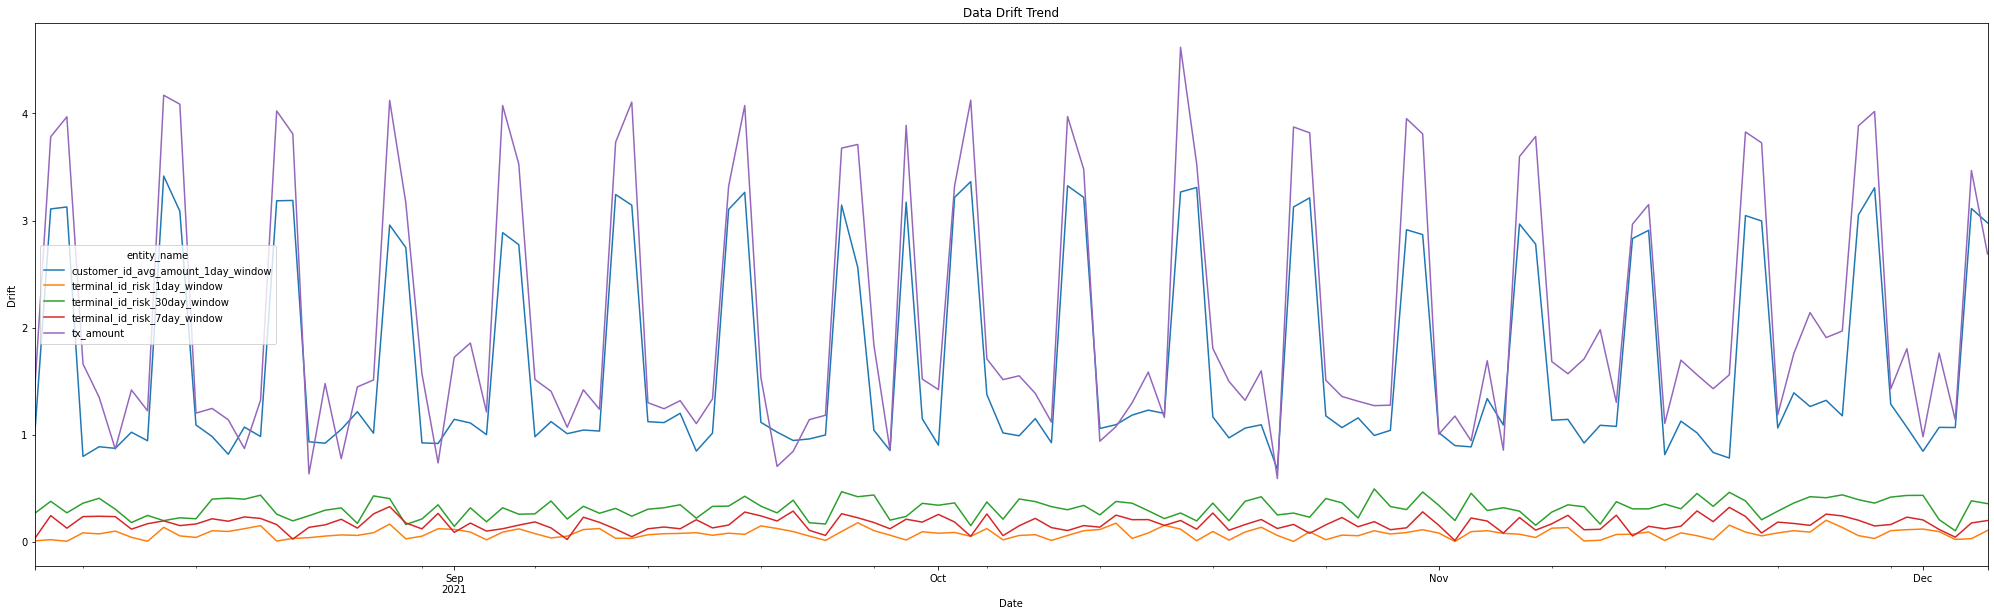

In [ ]:
plot_df = results_df.pivot(index='date_hour', columns='entity_name', values='value')
plot_df.plot(figsize=(35,10), title='Data Drift Trend', legend=True, xlabel='Date', ylabel='Drift')

## 📝 Tutorial Conclusion
In this tutorial, we demonstrated how you can easily query Superwise to get meaningful KPIs and visualize them to gain insight into your models.